# Quanvolutional Neural Networks

### General setup

In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [8]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "quanvolution/"  # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

In [4]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 10s 1us/step


## Quantum circuit as a convolution kernel
The process involves initializing a quantum device, generating random parameters for the quantum circuit, defining a quantum node, encoding classical inputs into the quantum circuit, Random quantum circuit, and measuring the resulting quantum state

In [5]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

### convolution
- The `quanv` function performs a quantum convolution on an input image by applying a quantum circuit to each 2x2 region of the image. 
- The results are stored in a smaller output array, effectively reducing the image size while capturing quantum-processed features. 


In [6]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

### Quantum pre-processing of the dataset

This code performs quantum preprocessing on training and test images using the quanv function. If preprocessing is enabled, it processes each image, saves the results, and then loads the preprocessed images for further use.


In [9]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


### visualize the effect of the quantum convolution layer

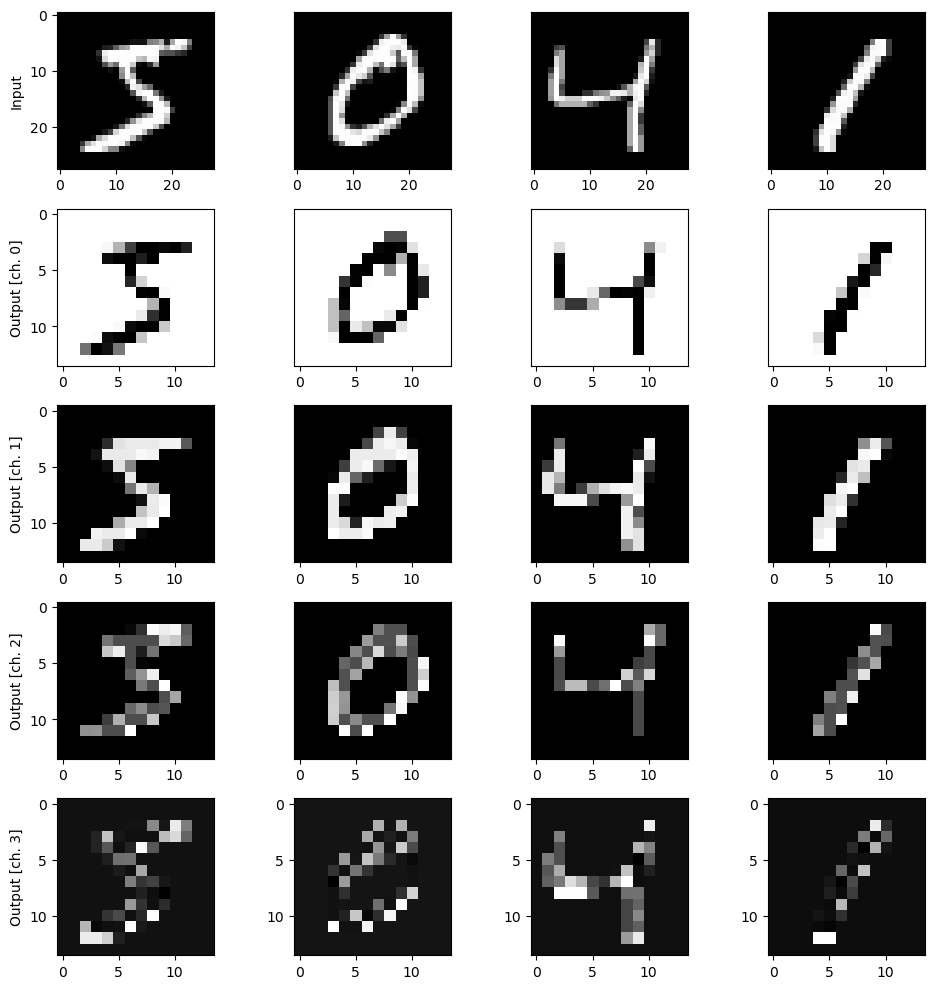

In [10]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

### Hybrid quantum-classical model
The MyModel function initializes a simple Keras model with a flattening layer and a dense layer with softmax activation. It compiles the model with the Adam optimizer, sparse categorical cross-entropy loss, and accuracy as the evaluation metric.

In [11]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

## Training


### Quantum model and classical model 
This code initializes a custom Keras model and trains it on the preprocessed training images and labels. The training process is monitored using validation data, and the progress is displayed in a detailed manner. The History object returned by the fit method can be used to analyze the training performance.

In [12]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 2s - 180ms/step - accuracy: 0.2200 - loss: 2.6601 - val_accuracy: 0.2000 - val_loss: 2.3346
Epoch 2/30
13/13 - 0s - 10ms/step - accuracy: 0.3400 - loss: 1.9675 - val_accuracy: 0.4333 - val_loss: 2.0566
Epoch 3/30
13/13 - 0s - 9ms/step - accuracy: 0.5800 - loss: 1.6299 - val_accuracy: 0.4667 - val_loss: 1.8740
Epoch 4/30
13/13 - 0s - 23ms/step - accuracy: 0.7400 - loss: 1.3121 - val_accuracy: 0.5667 - val_loss: 1.7324
Epoch 5/30
13/13 - 0s - 9ms/step - accuracy: 0.8400 - loss: 1.0789 - val_accuracy: 0.6333 - val_loss: 1.6148
Epoch 6/30
13/13 - 0s - 9ms/step - accuracy: 0.8800 - loss: 0.8969 - val_accuracy: 0.6667 - val_loss: 1.5259
Epoch 7/30
13/13 - 0s - 10ms/step - accuracy: 0.9600 - loss: 0.7519 - val_accuracy: 0.6667 - val_loss: 1.4557
Epoch 8/30
13/13 - 0s - 22ms/step - accuracy: 0.9600 - loss: 0.6344 - val_accuracy: 0.6667 - val_loss: 1.3966
Epoch 9/30
13/13 - 0s - 10ms/step - accuracy: 0.9800 - loss: 0.5412 - val_accuracy: 0.6667 - val_loss: 1.3492
Epoch 10/30


In [13]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 2s - 116ms/step - accuracy: 0.1600 - loss: 2.4310 - val_accuracy: 0.2333 - val_loss: 2.1895
Epoch 2/30
13/13 - 0s - 21ms/step - accuracy: 0.3800 - loss: 2.0166 - val_accuracy: 0.2667 - val_loss: 2.0605
Epoch 3/30
13/13 - 0s - 10ms/step - accuracy: 0.5600 - loss: 1.7275 - val_accuracy: 0.3333 - val_loss: 1.9384
Epoch 4/30
13/13 - 0s - 11ms/step - accuracy: 0.6400 - loss: 1.4883 - val_accuracy: 0.3667 - val_loss: 1.8222
Epoch 5/30
13/13 - 0s - 11ms/step - accuracy: 0.7800 - loss: 1.2874 - val_accuracy: 0.4333 - val_loss: 1.7173
Epoch 6/30
13/13 - 0s - 10ms/step - accuracy: 0.8600 - loss: 1.1194 - val_accuracy: 0.4667 - val_loss: 1.6266
Epoch 7/30
13/13 - 0s - 10ms/step - accuracy: 0.8600 - loss: 0.9792 - val_accuracy: 0.4667 - val_loss: 1.5496
Epoch 8/30
13/13 - 0s - 9ms/step - accuracy: 0.9000 - loss: 0.8621 - val_accuracy: 0.4667 - val_loss: 1.4844
Epoch 9/30
13/13 - 0s - 9ms/step - accuracy: 0.9400 - loss: 0.7636 - val_accuracy: 0.5333 - val_loss: 1.4290
Epoch 10/30

## Result
This code creates a figure with two subplots to compare the validation accuracy and loss of two models (one with a quantum layer and one without) over multiple epochs.  

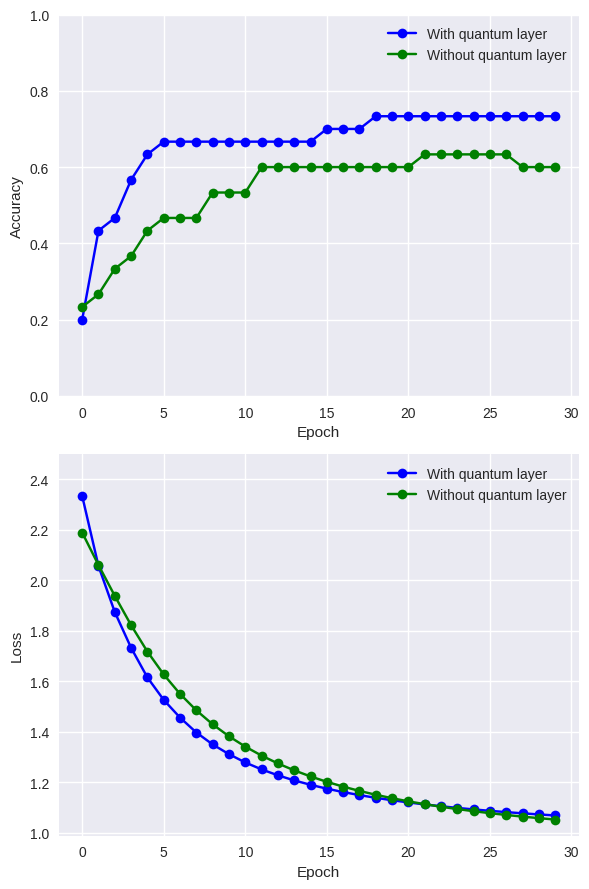

In [14]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

Above graph contains two line graphs comparing the performance of models with and without a quantum layer over multiple epochs.

### Accuracy Graph (Top)
- With Quantum Layer: The blue line shows that the model with the quantum layer achieves around **70% accuracy**.
- Without Quantum Layer: The green line shows that the model without the quantum layer achieves around **60% accuracy**.

### Loss Graph (Bottom)
- With Quantum Layer: The blue line indicates that the loss decreases rapidly and stabilizes.
- Without Quantum Layer: The green line shows a slower decrease in loss, stabilizes.

Overall, the model with the quantum layer performs better, achieving higher accuracy and lower loss compared to the model without the quantum layer.


# References
- Maxwell Henderson, Samriddhi Shakya, Shashindra Pradhan, Tristan Cook. “Quanvolutional Neural Networks: Powering Image Recognition with Quantum Circuits.” [arXiv:1904.04767](https://arxiv.org/abs/1904.04767), 2019.
- https://pennylane.ai/qml/demos/tutorial_quanvolution/